<a href="https://colab.research.google.com/github/kkrysw/ForkCast/blob/main/Data_for_ForkCast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import csv
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

import requests
import folium
import json
from typing import List, Dict
from IPython.display import display, HTML

# initial analysis of open/closed restaurants (2024/2017)

In [ ]:
inspections_2024_df=pd.read_csv('/content/2024_nyc_inspections.csv')
inspections_2024_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point1'],
      dtype='object')

In [ ]:
inspections_2017_df=pd.read_csv('/content/2017_nyc_inspections.csv')
inspections_2017_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')

In [ ]:
inspections_2024_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68812 entries, 0 to 68811
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  68812 non-null  int64  
 1   DBA                    68812 non-null  object 
 2   BORO                   68812 non-null  object 
 3   BUILDING               68712 non-null  object 
 4   STREET                 68810 non-null  object 
 5   ZIPCODE                68101 non-null  float64
 6   PHONE                  68810 non-null  object 
 7   CUISINE DESCRIPTION    67327 non-null  object 
 8   INSPECTION DATE        68812 non-null  object 
 9   ACTION                 67327 non-null  object 
 10  VIOLATION CODE         66850 non-null  object 
 11  VIOLATION DESCRIPTION  66850 non-null  object 
 12  CRITICAL FLAG          68812 non-null  object 
 13  SCORE                  64804 non-null  float64
 14  GRADE                  32715 non-null  object 
 15  GR

In [ ]:
inspections_2017_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80441 entries, 0 to 80440
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  80441 non-null  int64  
 1   DBA                    80361 non-null  object 
 2   BORO                   80441 non-null  object 
 3   BUILDING               80415 non-null  object 
 4   STREET                 80439 non-null  object 
 5   ZIPCODE                80439 non-null  float64
 6   PHONE                  80440 non-null  object 
 7   CUISINE DESCRIPTION    80441 non-null  object 
 8   INSPECTION DATE        80441 non-null  object 
 9   ACTION                 80204 non-null  object 
 10  VIOLATION CODE         79146 non-null  object 
 11  VIOLATION DESCRIPTION  79059 non-null  object 
 12  CRITICAL FLAG          80441 non-null  object 
 13  SCORE                  75690 non-null  float64
 14  GRADE                  39093 non-null  object 
 15  GR

In [ ]:
common_columns = inspections_2017_df.columns.intersection(inspections_2024_df.columns)

# keep just columns in common
inspections_2017_df_filtered = inspections_2017_df[common_columns]
inspections_2024_df_filtered = inspections_2024_df[common_columns]

In [ ]:
# Add a source column to indicate the source of each DataFrame
inspections_2017_df_filtered.loc[:, 'SOURCE'] = '2017'
inspections_2024_df_filtered.loc[:, 'SOURCE'] = '2024'

# Combine dataframes with all rows
combined_df = pd.concat([inspections_2017_df_filtered, inspections_2024_df_filtered], ignore_index=True)

<ipython-input-12-3130eca9a153>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspections_2024_df_filtered.loc[:, 'SOURCE'] = '2024'


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149253 entries, 0 to 149252
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  149253 non-null  int64  
 1   DBA                    149173 non-null  object 
 2   BORO                   149253 non-null  object 
 3   BUILDING               149127 non-null  object 
 4   STREET                 149249 non-null  object 
 5   ZIPCODE                148540 non-null  float64
 6   PHONE                  149250 non-null  object 
 7   CUISINE DESCRIPTION    147768 non-null  object 
 8   INSPECTION DATE        149253 non-null  object 
 9   ACTION                 147531 non-null  object 
 10  VIOLATION CODE         145996 non-null  object 
 11  VIOLATION DESCRIPTION  145909 non-null  object 
 12  CRITICAL FLAG          149253 non-null  object 
 13  SCORE                  140494 non-null  float64
 14  GRADE                  71808 non-nul

In [ ]:
combined_df['CAMIS'].nunique()

37389

In [ ]:
# keep camis, dba, cuisine, inspection, violation, critical, score, grade, status
combined_df=combined_df.drop(columns=['PHONE','ACTION','GRADE DATE','RECORD DATE','INSPECTION TYPE'])

# convert date columns to datetime
combined_df['INSPECTION DATE'] = pd.to_datetime(combined_df['INSPECTION DATE'])

# drop if camis, dba, street, zipcode, violation description, critical flag is null
combined_df=combined_df.dropna(subset=['CAMIS','DBA','STREET','ZIPCODE','VIOLATION DESCRIPTION','CRITICAL FLAG'])

# combine address columns into one
combined_df['BUILDING'] = combined_df['BUILDING'].fillna("")
combined_df['STREET'] = combined_df['STREET'].fillna("")
combined_df['ZIPCODE'] = pd.to_numeric(combined_df['ZIPCODE'], errors='coerce')
combined_df['ZIPCODE'] = combined_df['ZIPCODE'].fillna(0).astype(int).astype(str)
combined_df['BORO'] = combined_df['BORO'].fillna("")

# Replace 'Manhattan' with 'New York' in the BORO column
combined_df['BORO'] = combined_df['BORO'].replace("Manhattan", "New York")
combined_df['BORO'] = combined_df['BORO'].replace("MANHATTAN", "New York")
combined_df['BORO'] = combined_df['BORO'].str.capitalize()

# Concatenate columns to create the ADDRESS column
combined_df['ADDRESS'] = combined_df['BUILDING'] + " " + combined_df['STREET'] + ", " + combined_df['BORO'] + ", NY " + combined_df['ZIPCODE']

# Strip any excess spaces that may arise from missing data
combined_df['ADDRESS'] = combined_df['ADDRESS'].str.strip()

# Convert New York back to Manhattan
combined_df['BORO'] = combined_df['BORO'].replace("New york", "Manhattan")

# drop unneeded
combined_df=combined_df.drop(columns=['BUILDING','STREET','ZIPCODE'])

# rename as needed
combined_df = combined_df.rename(columns={
    'CAMIS':'id',
    'DBA':'name',
    'BORO':'boro'
})
combined_df.columns = combined_df.columns.str.lower()

# Apply str.title() to all object (string) columns
string_columns = ['name', 'address', 'boro', 'cuisine description']

for col in string_columns:
  combined_df[col]=combined_df[col].str.title()

combined_df.sample(3)

<ipython-input-15-e097d7d48b30>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['BUILDING'] = combined_df['BUILDING'].fillna("")
<ipython-input-15-e097d7d48b30>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['STREET'] = combined_df['STREET'].fillna("")
<ipython-input-15-e097d7d48b30>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,id,name,boro,cuisine description,inspection date,violation code,violation description,critical flag,score,grade,source,address
130007,50114524,Jooy Tea Shoppe,Brooklyn,Coffee/Tea,2023-02-23,04L,Evidence of mice or live mice in establishment...,Critical,30.0,C,2024,"5306 8 Avenue, Brooklyn, Ny 11220"
8708,50048254,Snow & Cream,Brooklyn,American,2016-10-18,08A,Facility not vermin proof. Harborage or condit...,Not Critical,17.0,NaN,2017,"6116 7Th Ave, Brooklyn, Ny 11220"
43783,41648461,Tropic Pollo,Queens,Peruvian,2017-04-06,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,30.0,NaN,2017,"9059 Corona Avenue, Queens, Ny 11373"


In [ ]:
# determine source column value
def determine_status(row, ids_2017, ids_2024, names_2017, names_2024):
    # check if id in either/or/both
    if row['id'] in ids_2017 and row['id'] in ids_2024:
        return 'open'
    elif row['name'].lower() in names_2017 and row['name'].lower() in names_2024:
        return 'open'
    elif row['id'] in ids_2017 and row['id'] not in ids_2024:
        return 'closed'
    elif row['id'] in ids_2024 and row['id'] not in ids_2017:
        return 'open'
    return 'unknown'

# get unique sets of id and restaurant names from the combined dataset
ids_2017 = set(combined_df[combined_df['source'] == '2017']['id'])
ids_2024 = set(combined_df[combined_df['source'] == '2024']['id'])

names_2017 = set(combined_df[combined_df['source'] == '2017']['name'].str.lower())
names_2024 = set(combined_df[combined_df['source'] == '2024']['name'].str.lower())

combined_df['status'] = combined_df.apply(determine_status, axis=1, args=(ids_2017, ids_2024, names_2017, names_2024))

# drop source once unneeded
combined_df = combined_df.drop(columns=['source'])

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145248 entries, 0 to 149252
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     145248 non-null  int64         
 1   name                   145248 non-null  object        
 2   boro                   145248 non-null  object        
 3   cuisine description    145248 non-null  object        
 4   inspection date        145248 non-null  datetime64[ns]
 5   violation code         145248 non-null  object        
 6   violation description  145248 non-null  object        
 7   critical flag          145248 non-null  object        
 8   score                  139168 non-null  float64       
 9   grade                  71065 non-null   object        
 10  address                145248 non-null  object        
 11  status                 145248 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), objec

In [ ]:
grouped_df = combined_df.groupby(['id']).agg({
    'name':'first',
    'address': 'first',
    'boro': 'first',  # Keep one representative value (same for all rows in the group)
    'cuisine description': 'first',
    'inspection date': list,  # Collect all inspection dates into a list
    'violation code': list,  # Collect all violation codes into a list
    'violation description': list,
    'critical flag': list,
    'score': list,
    'grade': list,
    'status': 'first'  # Keep one representative value (same for all rows in the group)
}).reset_index()
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35454 entries, 0 to 35453
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     35454 non-null  int64 
 1   name                   35454 non-null  object
 2   address                35454 non-null  object
 3   boro                   35454 non-null  object
 4   cuisine description    35454 non-null  object
 5   inspection date        35454 non-null  object
 6   violation code         35454 non-null  object
 7   violation description  35454 non-null  object
 8   critical flag          35454 non-null  object
 9   score                  35454 non-null  object
 10  grade                  35454 non-null  object
 11  status                 35454 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.2+ MB


In [ ]:
grouped_df.sample(5)

,id,name,address,boro,cuisine description,inspection date,violation code,violation description,critical flag,score,grade,status
3239,40958138,Bowery Bay Tavern,"0 Laguardia Airport, Queens, Ny 11369",Queens,American,"[2017-04-20 00:00:00, 2014-05-08 00:00:00]","[10F, 06D]",[Non-food contact surface improperly construct...,"[Not Critical, Critical]","[5.0, 11.0]","[A, A]",closed
2473,40803254,Palma,"28 Cornelia Street, New York, Ny 10014",Manhattan,Italian,"[2015-02-26 00:00:00, 2014-07-02 00:00:00, 201...","[02G, 10H, 06F, 04L, 06C, 08A, 10F, 06D]",[Cold food item held above 41Âº F (smoked fish...,"[Critical, Not Critical, Critical, Critical, C...","[20.0, 9.0, 13.0, 12.0, 13.0, 9.0, 13.0, 13.0]","[nan, A, A, nan, A, A, A, A]",open
16197,50016832,Joy Burger Bar,"1567 Lexington Ave, New York, Ny 10029",Manhattan,Hamburgers,"[2015-01-07 00:00:00, 2015-12-08 00:00:00, 201...","[08A, 10I, 04C, 04N, 04J, 08A, 04N, 04M, 04L]",[Facility not vermin proof. Harborage or condi...,"[Not Critical, Not Critical, Critical, Critica...","[26.0, 22.0, 26.0, 22.0, 26.0, 12.0, 13.0, 23....","[B, nan, B, nan, B, A, A, nan, A]",closed
787,40396020,French Roast,"78 West 11 Street, New York, Ny 10011",Manhattan,French,"[2017-05-18 00:00:00, 2017-05-18 00:00:00, 201...","[02G, 10B, 06C, 10F, 04L, 09E, 04L, 06D, 08A, ...",[Cold food item held above 41Âº F (smoked fish...,"[Critical, Not Critical, Critical, Not Critica...","[36.0, 36.0, 12.0, 5.0, 36.0, 12.0, 26.0, 13.0...","[nan, nan, A, A, nan, A, nan, A, nan, nan, nan]",open
9685,41588604,2Nd Avenue Deli,"1442 1 Avenue, New York, Ny 10021",Manhattan,Jewish/Kosher,"[2014-08-18 00:00:00, 2024-02-06 00:00:00, 202...","[04N, 10F, 10B, 02B]",[Filth flies or food/refuse/sewage-associated ...,"[Critical, Not Critical, Not Critical, Critical]","[10.0, 3.0, 29.0, 29.0]","[A, A, nan, nan]",open


In [ ]:
# Apply str.title() to all object (string) columns
string_columns = ['name', 'address', 'boro', 'cuisine description', 'status']

for col in string_columns:
    grouped_df[col] = grouped_df[col].str.title()

# If nested list columns also contain strings, you can handle them similarly
def capitalize_nested_lists(column):
    return column.apply(lambda x: [s.title() if isinstance(s, str) else s for s in x])

list_columns = ['inspection date', 'violation code', 'violation description', 'critical flag', 'grade']

for col in list_columns:
    grouped_df[col] = capitalize_nested_lists(grouped_df[col])

grouped_df.sample(3)


,id,name,address,boro,cuisine description,inspection date,violation code,violation description,critical flag,score,grade,status
6233,41329984,El Anzuelo Fino,"8601 Northern Boulevard, Queens, Ny 11372",Queens,Peruvian,"[2015-01-31 00:00:00, 2016-03-04 00:00:00, 201...","[16B, 06C, 06B, 04L, 06C, 10I, 10F, 22C]",[The Original Nutritional Fact Labels And/Or I...,"[Not Critical, Critical, Critical, Critical, C...","[nan, 17.0, 25.0, 25.0, 12.0, 15.0, 3.0, nan]","[nan, nan, nan, nan, A, B, A, nan]",Closed
18825,50043917,Panini Tozt C.A.F.E,"2502 Queens Plz S, Queens, Ny 11101",Queens,American,"[2017-03-22 00:00:00, 2017-03-22 00:00:00, 201...","[06D, 02B, 10F, 10B]","[Food Contact Surface Not Properly Washed, Rin...","[Critical, Critical, Not Critical, Not Critical]","[23.0, 23.0, 13.0, 13.0]","[nan, nan, A, A]",Closed
32312,50133239,Zara Forest,"1745 Forest Avenue, Staten Island, Ny 10303",Staten Island,Turkish,"[2023-08-17 00:00:00, 2023-08-17 00:00:00, 202...","[10B, 10D, 08A, 08C, 04C]",[Anti-Siphonage Or Back-Flow Prevention Device...,"[Not Critical, Not Critical, Not Critical, Not...","[10.0, 10.0, 49.0, 10.0, 49.0]","[A, A, nan, A, nan]",Open


In [ ]:
status_counts = grouped_df['status'].value_counts()
print(status_counts)

status
Open      25273
Closed    10181
Name: count, dtype: int64



Key Findings:
Total unique restaurants: 35,454
Average inspections per restaurant: 4.10

Grade Distribution:
A: 52,691
B: 9,510
C: 3,748
N: 2,406
Z: 1,738
Not Yet Graded: 533
P: 439

Score Stats:
Min score: -1.00
Max score: 168.00
Mean score: 21.43
Median score: 17.00
Std dev score: 15.78

Restaurant Counts by Borough:
Manhattan: 55,639
Brooklyn: 37,975
Queens: 33,777
Bronx: 12,763
Staten Island: 5,094


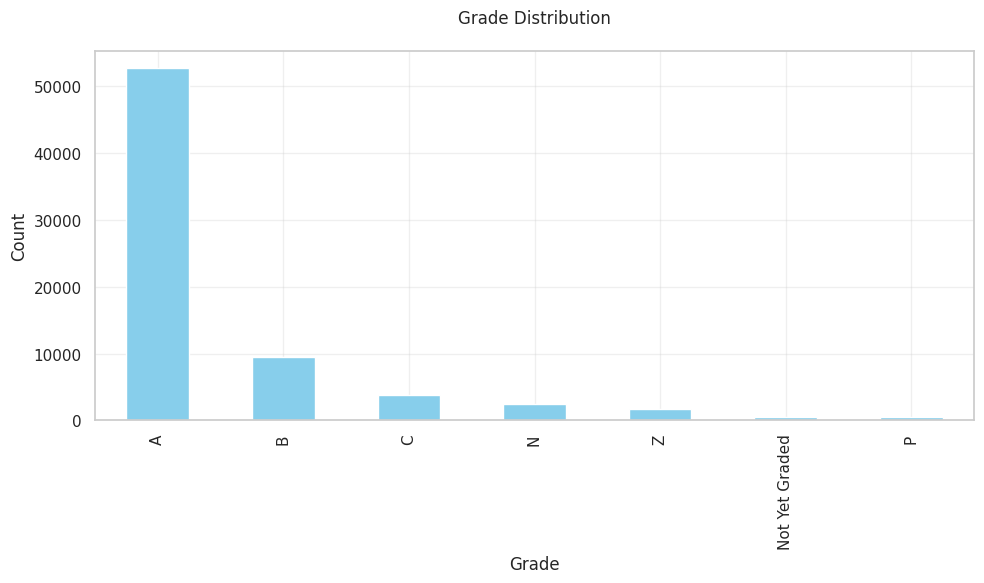

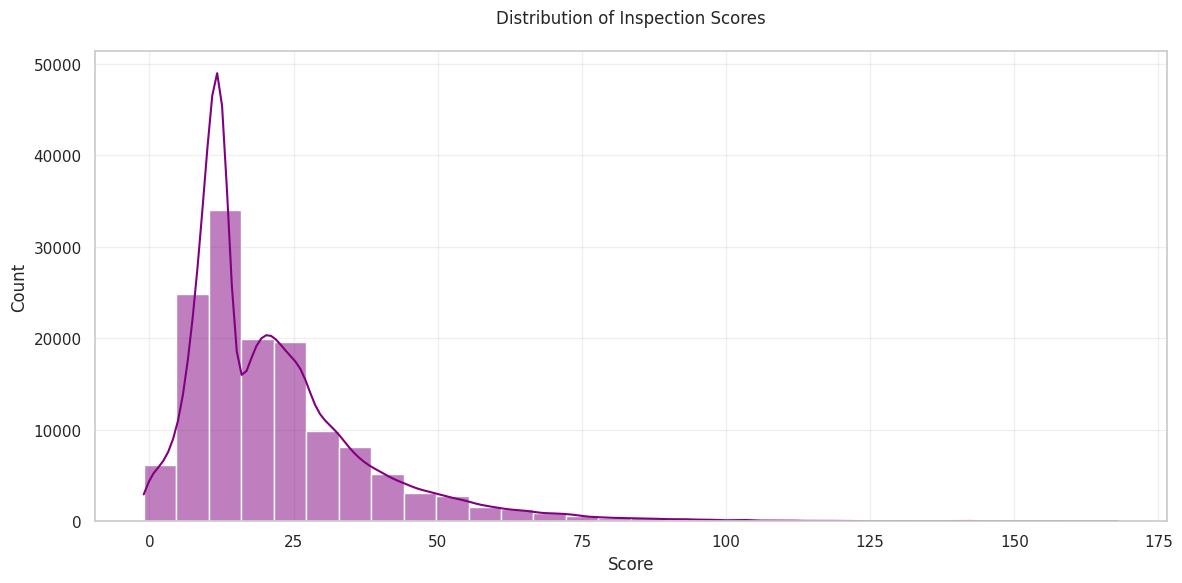

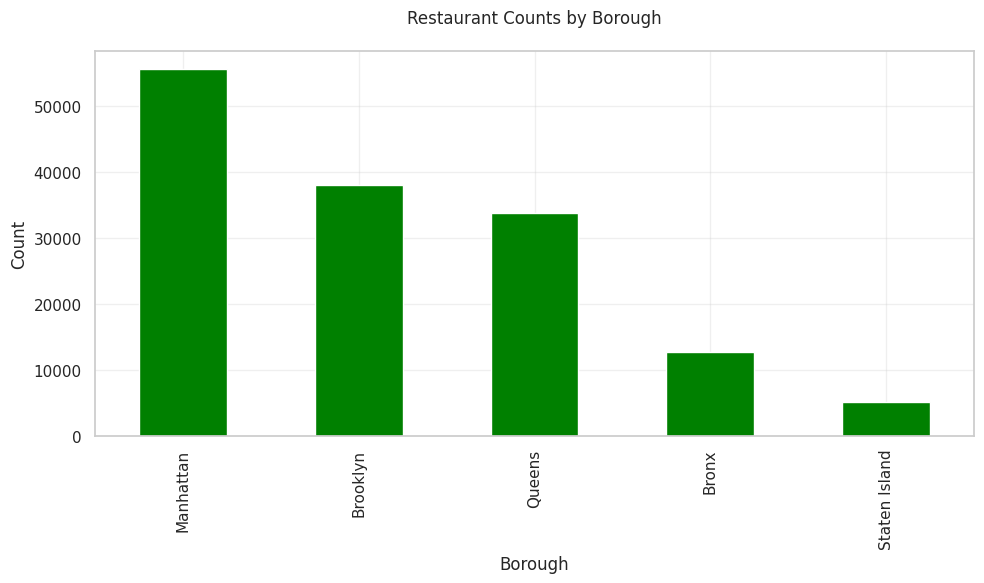

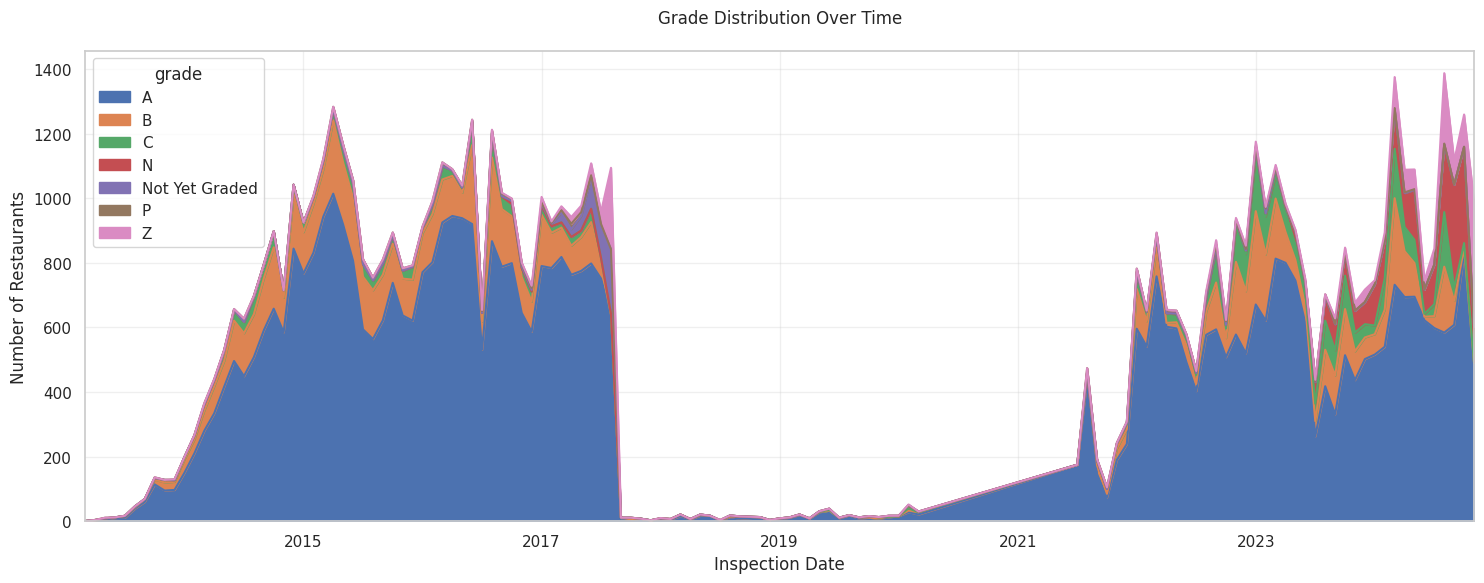

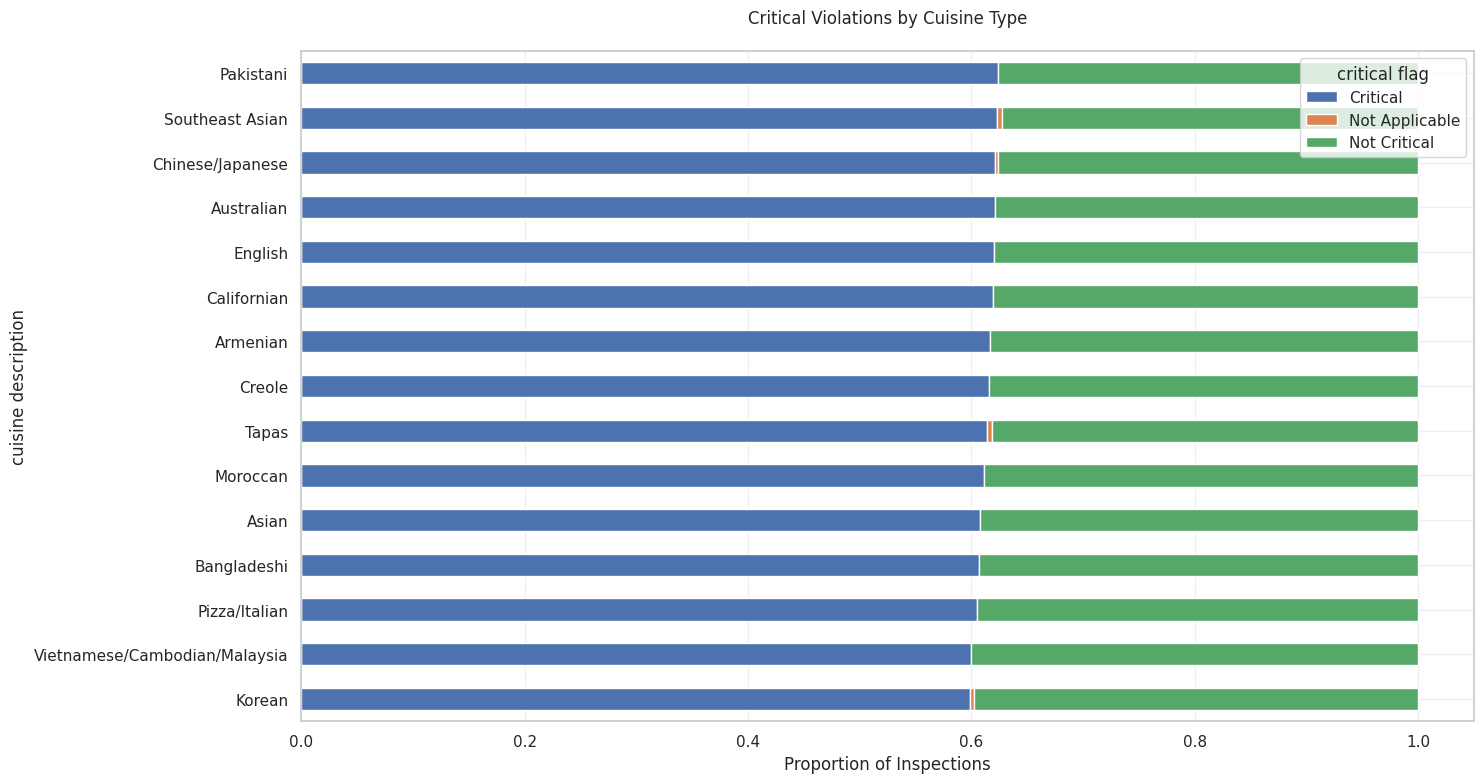

In [ ]:
def perform_eda(df):
    """Perform exploratory data analysis on restaurant inspection data."""
    analysis = {} # this stores my results yay

    # (1) stats
    analysis['total_restaurants'] = df['id'].nunique()
    analysis['total_inspections'] = len(df)
    analysis['avg_inspections_per_restaurant'] = len(df) / df['id'].nunique()

    # (2) distribution of grades
    grade_dist = df['grade'].value_counts().to_dict()
    analysis['grade_distribution'] = grade_dist

    # distribution of scores
    analysis['score_distribution'] = {
        'min_score': df['score'].min(),
        'max_score': df['score'].max(),
        'mean_score': df['score'].mean(),
        'median_score': df['score'].median(),
        'std_dev_score': df['score'].std(),
    }


    # (3) critical violations
    analysis['critical_violations_pct'] = (
        df['critical flag'].value_counts(normalize=True)
        .to_dict()
    )

    # (4) top violation codes
    analysis['top_violations'] = (
        df['violation code']
        .value_counts()
        .head(10)
        .to_dict()
    )

    # (5) cuisine types
    analysis['cuisine_counts'] = (
        df['cuisine description']
        .value_counts()
        .head(10)
        .to_dict()
    )

    # (7) Borough counts
    analysis['boro_counts'] = df['boro'].value_counts().to_dict()

    return analysis

def create_visualizations(df):
    """Create visualizations for key insights."""
    # Set modern style defaults
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    sns.set_theme(style="whitegrid")

    # (1) Grade distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    df['grade'].value_counts().plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title('Grade Distribution', pad=20)
    ax.set_xlabel('Grade')
    ax.set_ylabel('Count')
    fig.tight_layout()

    # (2) Score distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(data=df, x='score', bins=30, ax=ax, kde=True, color='purple')
    ax.set_title('Distribution of Inspection Scores', pad=20)
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    fig.tight_layout()

    # (3) Borough counts
    fig, ax = plt.subplots(figsize=(10, 6))
    df['boro'].value_counts().plot(kind='bar', ax=ax, color='green')
    ax.set_title('Restaurant Counts by Borough', pad=20)
    ax.set_xlabel('Borough')
    ax.set_ylabel('Count')
    fig.tight_layout()

    # (1a) grade distribution over time
    fig, ax = plt.subplots(figsize=(15, 6))
    grade_time = df.pivot_table(
        index=df['inspection date'].dt.to_period('M'),
        columns='grade',
        values='id',
        aggfunc='count'
    ).fillna(0)
    grade_time.plot(kind='area', stacked=True, ax=ax)
    ax.set_title('Grade Distribution Over Time', pad=20)
    ax.set_xlabel('Inspection Date')
    ax.set_ylabel('Number of Restaurants')
    fig.tight_layout()

    # (3) critical violations by cuisine type
    fig, ax = plt.subplots(figsize=(15, 8))
    cuisine_critical = df.groupby('cuisine description')['critical flag'].value_counts(normalize=True).unstack()
    # Handle inf values by converting to NaN
    cuisine_critical = cuisine_critical.replace([np.inf, -np.inf], np.nan)
    cuisine_critical.sort_values('Critical', ascending=True).tail(15).plot(
        kind='barh',
        stacked=True,
        ax=ax
    )
    ax.set_title('Critical Violations by Cuisine Type', pad=20)
    ax.set_xlabel('Proportion of Inspections')
    fig.tight_layout()


def analyze_temporal_patterns(df):
    """Analyze temporal patterns in inspections and violations."""
    temporal_analysis = {}

    # (1) day of week
    df['day_of_week'] = df['inspection date'].dt.day_name()
    temporal_analysis['inspections_by_day'] = (
        df['day_of_week']
        .value_counts()
        .reindex(list(calendar.day_name))
        .to_dict()
    )

    # (2) month
    df['month'] = df['inspection date'].dt.month_name()
    temporal_analysis['inspections_by_month'] = (
        df['month']
        .value_counts()
        .reindex(list(calendar.month_name)[1:])
        .to_dict()
    )

    # (3) grade transitions
    grade_changes = df.sort_values('inspection date').groupby('id')['grade'].shift()
    temporal_analysis['grade_transitions'] = (
        pd.crosstab(df['grade'], grade_changes)
        .to_dict()
    )

    return temporal_analysis


def main():
    # Load data
    df = combined_df

    # Perform analyses
    basic_analysis = perform_eda(df)
    temporal_patterns = analyze_temporal_patterns(df)

    # Create visualizations
    create_visualizations(df)

    # Print key findings
    print("\nKey Findings:")
    print(f"Total unique restaurants: {basic_analysis['total_restaurants']:,}")
    print(f"Average inspections per restaurant: {basic_analysis['avg_inspections_per_restaurant']:.2f}")
    print("\nGrade Distribution:")
    for grade, count in basic_analysis['grade_distribution'].items():
        print(f"{grade}: {count:,}")
    print("\nScore Stats:")
    for stat, value in basic_analysis['score_distribution'].items():
        print(f"{stat.capitalize().replace('_', ' ')}: {value:.2f}" if isinstance(value, float) else f"{stat.capitalize().replace('_', ' ')}: {value}")
    print("\nRestaurant Counts by Borough:")
    for boro, count in basic_analysis['boro_counts'].items():
        print(f"{boro}: {count:,}")

    return basic_analysis, temporal_patterns

if __name__ == "__main__":
    basic_analysis, temporal_patterns = main()

In [ ]:
grouped_df.to_csv('inspections_results.csv', index=False)

# 12/3 checkpoint: use final_csv gathered yesterday and add onto it

In [ ]:
prev_final=pd.read_csv('/content/final.csv')
prev_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   inspection_id          3125 non-null   int64  
 1   name                   3125 non-null   object 
 2   status                 3125 non-null   object 
 3   boro                   3125 non-null   object 
 4   address                3125 non-null   object 
 5   rating                 3125 non-null   float64
 6   review_count           3125 non-null   int64  
 7   cuisine                3125 non-null   object 
 8   price                  2263 non-null   float64
 9   inspection_date        3125 non-null   object 
 10  violation_code         3125 non-null   object 
 11  violation_description  3125 non-null   object 
 12  critical_flag          3125 non-null   object 
 13  score                  3125 non-null   object 
 14  grade                  3125 non-null   object 
dtypes: f

In [ ]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35454 entries, 0 to 35453
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     35454 non-null  int64 
 1   name                   35454 non-null  object
 2   address                35454 non-null  object
 3   boro                   35454 non-null  object
 4   cuisine description    35454 non-null  object
 5   inspection date        35454 non-null  object
 6   violation code         35454 non-null  object
 7   violation description  35454 non-null  object
 8   critical flag          35454 non-null  object
 9   score                  35454 non-null  object
 10  grade                  35454 non-null  object
 11  status                 35454 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.2+ MB


In [ ]:
prev_subset=prev_final[['name','address']]
grouped_filtered = grouped_df[~grouped_df[['name', 'address']].apply(tuple, axis=1).isin(prev_subset.apply(tuple, axis=1))]
grouped_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32711 entries, 0 to 35453
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     32711 non-null  int64 
 1   name                   32711 non-null  object
 2   address                32711 non-null  object
 3   boro                   32711 non-null  object
 4   cuisine description    32711 non-null  object
 5   inspection date        32711 non-null  object
 6   violation code         32711 non-null  object
 7   violation description  32711 non-null  object
 8   critical flag          32711 non-null  object
 9   score                  32711 non-null  object
 10  grade                  32711 non-null  object
 11  status                 32711 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.2+ MB


# yelp api integration

In [ ]:
from sklearn.model_selection import train_test_split

sample_size = 5000
sample_fraction = sample_size / len(grouped_filtered)

# Perform stratified sampling to get 5000 rows
df_stratified, _ = train_test_split(grouped_filtered, stratify=grouped_filtered['status'], train_size=sample_fraction)

In [ ]:
df_stratified['status'].value_counts()

,count
status,
Open,3562
Closed,1438


In [ ]:
import requests
import pandas as pd
import csv
import time

# API setup
API_KEYS = [
    'StoYwOi-Dv6ooRDWAgRNe0Cvh_kbVRj4M_bo4xXaQ1ggvZeyAI9rvm2RM5jCQy8sx2glE46nfRqrLtw2H8-MUDjL2VQwUT25EX9qdITGoQjgNoTUlrJa1ZrCInBLZ3Yx',
    'UsdLueoFQO8lIEpPAzSEZr5J9ugA1oOJgrC3vMdedCW2vCi4WiVW-sWpdaqzum5kTCWd6Ufno89ykdQZ4ajotYOa1RwAaL1maUB4B6pKKLUjbjIx2ltOMJ17Mn5LZ3Yx',  # add more as needed
    'h0mftMH50uW9iV5xhqZf8gcT_g25BWtXIIaVzSO5ZNAu0f6jan89QI1u8qlsrEnU9BzKH2U_Bf0Z9Y-2XdA18HU_ArY8xZfzWnOe9g4TJfTM6tU_SYiNN7442n5LZ3Yx',
    'Jp45FfRUSKWr0TJw3ENkJClDNMXlSxkLfqGXU7xrLsuqK7sOZjxPeNcab6nOYzGDP3vIz75Ks9IGC_CGi9volp6KAOWV7OTHf_urBsGir-cLlh1ZKp7HAsFgZH9LZ3Yx',
    'iPAPO3dUWfTXM_AWj2Jmjn_JLskwX9LoSEID8o3A3eIJ8cHylE95ih79uktzrzSJC2Zp57iKQ2TGkfaPyQICIULT4qTqRsLWjJCPQGC0w31IQT1rEE8BWEQ8fL1KZ3Yx',
    'Jw6zBlJ02QnTvicq70Say1BD7P9lxgkxTh0nEDwCEtHmHtXwX7lLovIP3jdJ3YaN_TxaaPVgd7DPRVzOpj6HGpsISgg7RNJ0SChpu2WX5eqwvyC3rmOEfSM9_dpEZ3Yx',
    'fBll2rzVmjraupnqVjeknojKrD0ATK2JUPNyTo9c88UqBvF0ZElELGt793JxO2FUJQ79XEOgsmwERDBBYyuDbHsXp87G3NpqkWFgv5J-1vIPve66bhLim5T31tlEZ3Yx'
]
MAX_REQUESTS_PER_KEY = 500  # Yelp's daily limit per key
API_ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
DETAILS_ENDPOINT = 'https://api.yelp.com/v3/businesses/'

# Output file
output_file = 'yelp_restaurant_info.csv'
csv_headers = [
    'id', 'name', 'boro', 'cuisine', 'inspection_date', 'violation_code', 'violation_description',
    'critical_flag', 'score', 'grade', 'address', 'status', 'yelp_rating',
    'yelp_review_count', 'yelp_price'
]

# Initialize variables
key_index = 0
request_count = 0

def get_headers():
    """Rotate API key headers."""
    global key_index, request_count
    if request_count >= MAX_REQUESTS_PER_KEY:
        key_index = (key_index + 1) % len(API_KEYS)
        request_count = 0  # Reset count for the new key
        print(f"Switching to API Key {key_index + 1}")
    request_count += 1
    return {'Authorization': f'Bearer {API_KEYS[key_index]}'}

# Write to CSV
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=csv_headers)
    writer.writeheader()  # Write the header row

    # Iterate through each restaurant in the dataframe
    for index, row in df_stratified.iterrows():
        restaurant_name = row['name']
        address = row['address']

        print(f"Fetching Yelp info for {restaurant_name} at {address}...")

        # Yelp API search parameters
        params = {
            'term': restaurant_name,
            'location': address,
            'limit': 1  # Only get the first match
        }

        # Make API request
        headers = get_headers()
        response = requests.get(API_ENDPOINT, headers=headers, params=params)

        if response.status_code != 200:
            print(f"Error: Unable to fetch data for {restaurant_name} (Status code: {response.status_code})")
            continue

        data = response.json()
        businesses = data.get('businesses', [])

        if businesses:
            # Get the first match from the Yelp results
            biz = businesses[0]

            def convert_price_to_int(price):
                if price == 'N/A':
                    return None
                return len(price)

            yelp_info = {
                'id': row['id'],
                'name': row['name'],
                'address': row['address'],
                'boro': row['boro'],
                'cuisine': row['cuisine description'],
                'inspection_date': row['inspection date'],
                'violation_code': row['violation code'],
                'violation_description': row['violation description'],
                'critical_flag': row['critical flag'],
                'score': row['score'],
                'grade': row['grade'],
                'status': row['status'],
                'yelp_rating': biz.get('rating'),
                'yelp_review_count': biz.get('review_count'),
                'yelp_price': convert_price_to_int(biz.get('price', 'N/A')),
            }

            writer.writerow(yelp_info)
        else:
            print(f"No Yelp results found for {restaurant_name} at {address}.")

        time.sleep(1)

print("Data fetching complete!")

Streaming output truncated to the last 5000 lines.
Fetching Yelp info for Abc El Salvadorin Grocery Inc at 4620 5 Avenue, Brooklyn, Ny 11220...
No Yelp results found for Abc El Salvadorin Grocery Inc at 4620 5 Avenue, Brooklyn, Ny 11220.
Fetching Yelp info for The Village Green at 1417 150Th St, Queens, Ny 11357...
Fetching Yelp info for O'Sake Rockaway Japanese Restaurant at 263 Beach  116 Street, Queens, Ny 11694...
Fetching Yelp info for Subway at 1720 Eastchester Rd, Bronx, Ny 10461...
Fetching Yelp info for Birdland at 315 West   44 Street, New York, Ny 10036...
Fetching Yelp info for Flinders Lane at 162 Avenue A, New York, Ny 10009...
Fetching Yelp info for Teriyaki One at 870 Remsen Avenue, Brooklyn, Ny 11236...
Fetching Yelp info for Mary'S Cafe at 905 Dekalb Avenue, Brooklyn, Ny 11221...
Fetching Yelp info for Xokotl at 1605 Williamsbridge Road, Bronx, Ny 10461...
Fetching Yelp info for New China Restaurant at 271 Neptune Ave, Brooklyn, Ny 11235...
Fetching Yelp info for Heig

In [ ]:
yelp_df=pd.read_csv('yelp_restaurant_info.csv')
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3129 non-null   int64  
 1   name                   3129 non-null   object 
 2   boro                   3129 non-null   object 
 3   cuisine                3129 non-null   object 
 4   inspection_date        3129 non-null   object 
 5   violation_code         3129 non-null   object 
 6   violation_description  3129 non-null   object 
 7   critical_flag          3129 non-null   object 
 8   score                  3129 non-null   object 
 9   grade                  3129 non-null   object 
 10  address                3129 non-null   object 
 11  status                 3129 non-null   object 
 12  yelp_rating            3129 non-null   float64
 13  yelp_review_count      3129 non-null   int64  
 14  yelp_price             2312 non-null   float64
dtypes: f

In [ ]:
# Rename the columns
yelp_df.rename(columns={
    'id': 'inspection_id',
    'name': 'name',
    'status': 'status',
    'boro': 'boro',
    'address': 'address',
    'yelp_rating': 'rating',
    'yelp_review_count': 'review_count',
    'cuisine': 'cuisine',
    'yelp_price': 'price',
    'inspection_date': 'inspection_date',
    'violation_code': 'violation_code',
    'violation_description': 'violation_description',
    'critical_flag': 'critical_flag',
    'score': 'score',
    'grade': 'grade'
}, inplace=True)

# Reorder the columns
final_df2 = yelp_df[['inspection_id',  'name', 'status', 'boro', 'address', 'rating', 'review_count', 'cuisine', 'price', 'inspection_date', 'violation_code', 'violation_description', 'critical_flag', 'score', 'grade']]
# monday final
mon_final=pd.read_csv('/content/final.csv')

#combine mon and tue
final_df=pd.concat([mon_final,final_df2])
final_df.to_csv('final.csv', index=False)

#final_df.head()
final_df.tail(3)


,inspection_id,name,status,boro,address,rating,review_count,cuisine,price,inspection_date,violation_code,violation_description,critical_flag,score,grade
3126,50038370,Myst Hookah Lounge & Cafe,Open,Brooklyn,"2086 Coney Island Ave, Brooklyn, Ny 11223",3.4,272,Middle Eastern,2.0,"[Timestamp('2015-09-16 00:00:00'), Timestamp('...","['08A', '10F', '04N', '10F']",['Facility Not Vermin Proof. Harborage Or Cond...,"['Not Critical', 'Not Critical', 'Critical', '...","[11.0, 13.0, 23.0, 2.0]","[nan, 'A', nan, 'A']"
3127,41600154,Starbucks Coffee,Open,Manhattan,"122 Greenwich Avenue, New York, Ny 10011",4.8,18,Cafã©/Coffee/Tea,NaN,"[Timestamp('2014-07-10 00:00:00'), Timestamp('...","['06C', '10F', '10F', '10B']",['Food Not Protected From Potential Source Of ...,"['Critical', 'Not Critical', 'Not Critical', '...","[7.0, 5.0, 7.0, 9.0]","['A', 'A', 'A', 'A']"
3128,41688540,Food Depot,Closed,Manhattan,"460 West 34 Street, New York, Ny 10001",2.4,9,American,3.0,"[Timestamp('2014-04-04 00:00:00'), Timestamp('...","['02G', '06D']",['Cold Food Item Held Above 41Âº F (Smoked Fis...,"['Critical', 'Critical']","[29.0, 9.0]","[nan, 'A']"


In [ ]:
final_df['status'].value_counts()

,count
status,
Open,6827
Closed,2556


In [ ]:
print(final_df['violation_description'][0])

0    ["Live Roaches Present In Facility'S Food And/...
0    ['Food Not Protected From Potential Source Of ...
Name: violation_description, dtype: object
